**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [23]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import csv
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()

# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [24]:
X = sorted(glob('data/prediction/*.tif'))
X = list(map(imread,X))
    
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


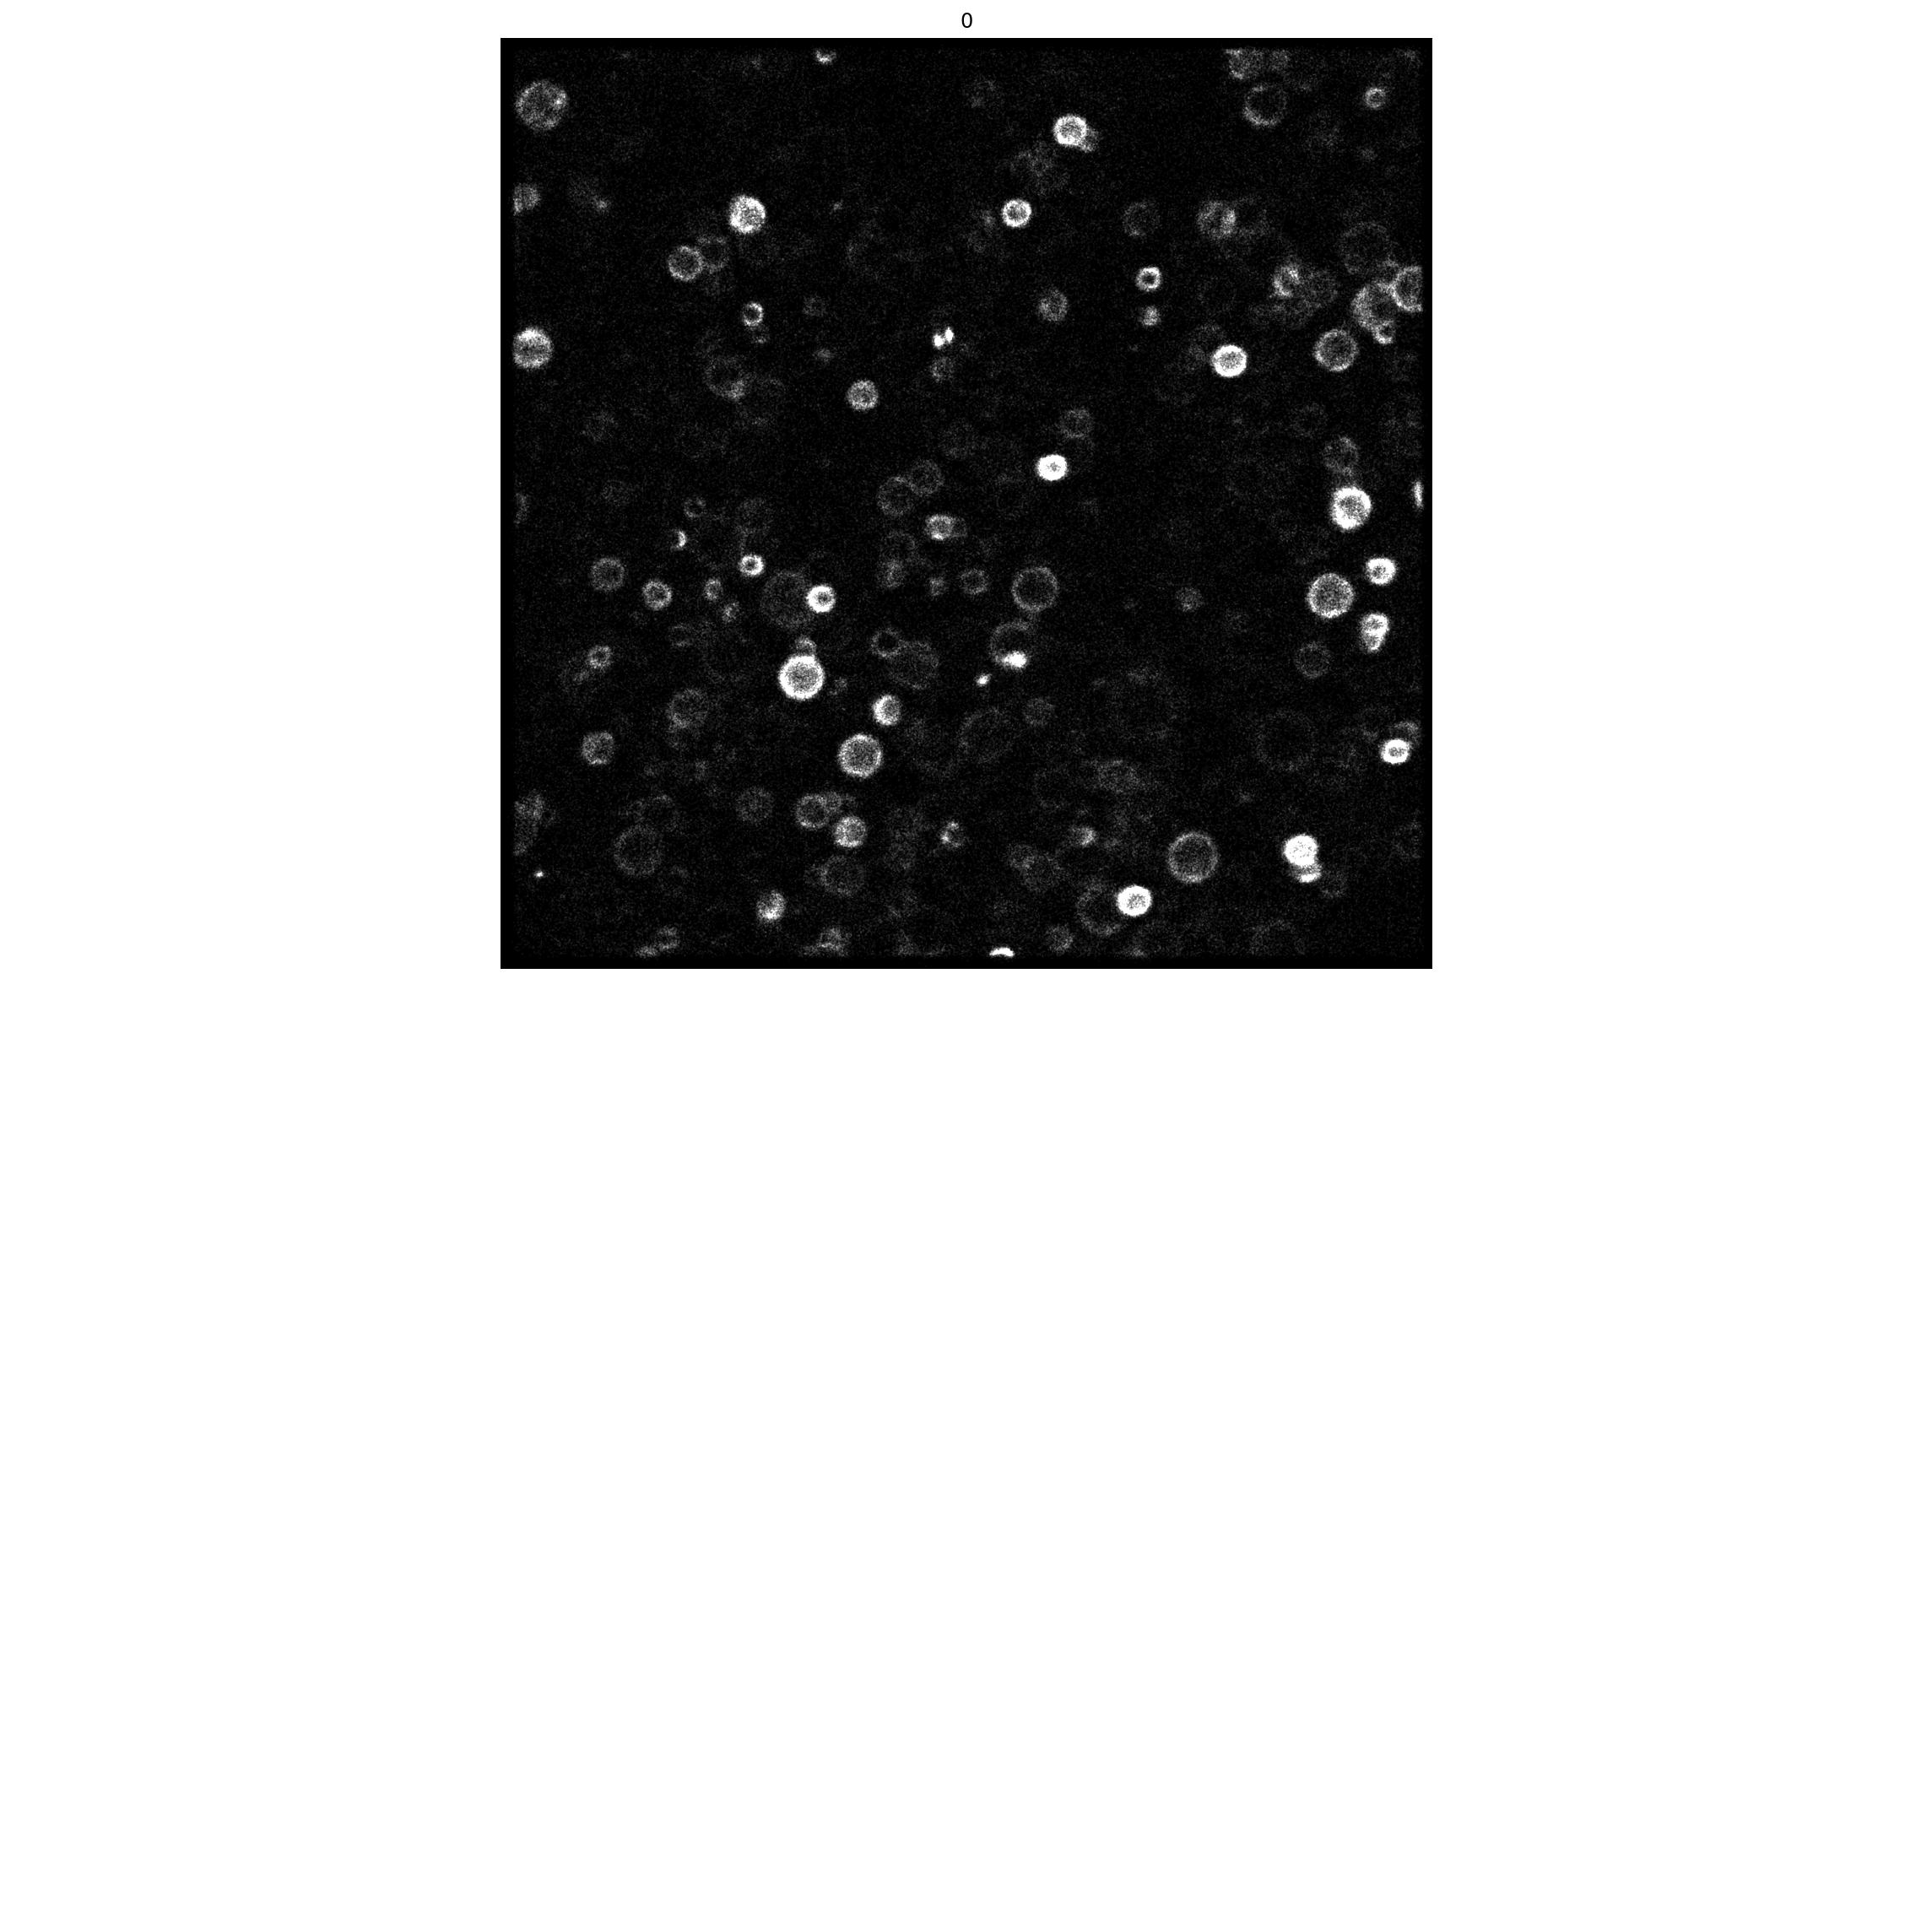

In [25]:
# show all test images
if True:
    fig, ax = plt.subplots(2,1, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [5]:
import os
list_models = os.listdir("models/")
for idx, mod in enumerate(list_models):
    print(str(idx) +" - " + mod)
selected = int(input("Select model \n"))
selected_model = list_models[selected]
print("\nModel selected: "+ selected_model)

0 - 20220523_194913_droplets
1 - 20220524_161628_droplets
2 - 20220525_160909_droplets
3 - 20220607_175021_droplets
4 - 3_az_hame_behtare.txt
5 - stardist


Select model 
 3



Model selected: 20220607_175021_droplets


In [6]:
demo_model = False

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model = StarDist2D(None, name=selected_model, basedir='models')
None;

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.5, nms_thresh=0.5.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [41]:
img =normalize(X[0], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

1/1 [==============================] - 5s 5s/step


In [35]:
path = r'D:\OneDrive\OneDrive - Wageningen University & Research\Paper\Thesis\Chapter 6\Depth analysis\8micron depth'

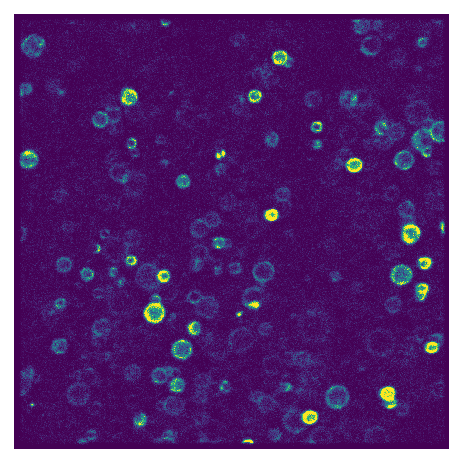

In [36]:
plt.imshow(img)
plt.axis('off');
plt.savefig(path +r'\20220427_orgwi.png',dpi=600)

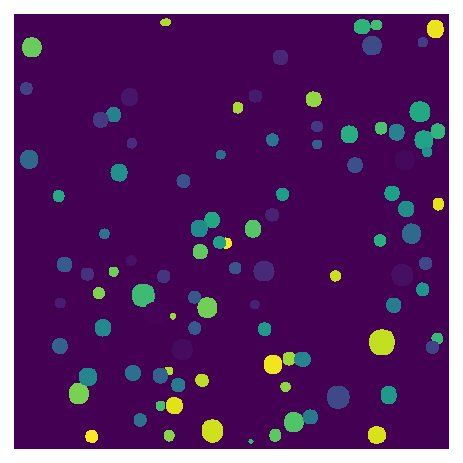

In [37]:
plt.imshow(labels)
plt.axis('off');
plt.savefig(path +r"\20220427_org.png",dpi=600)

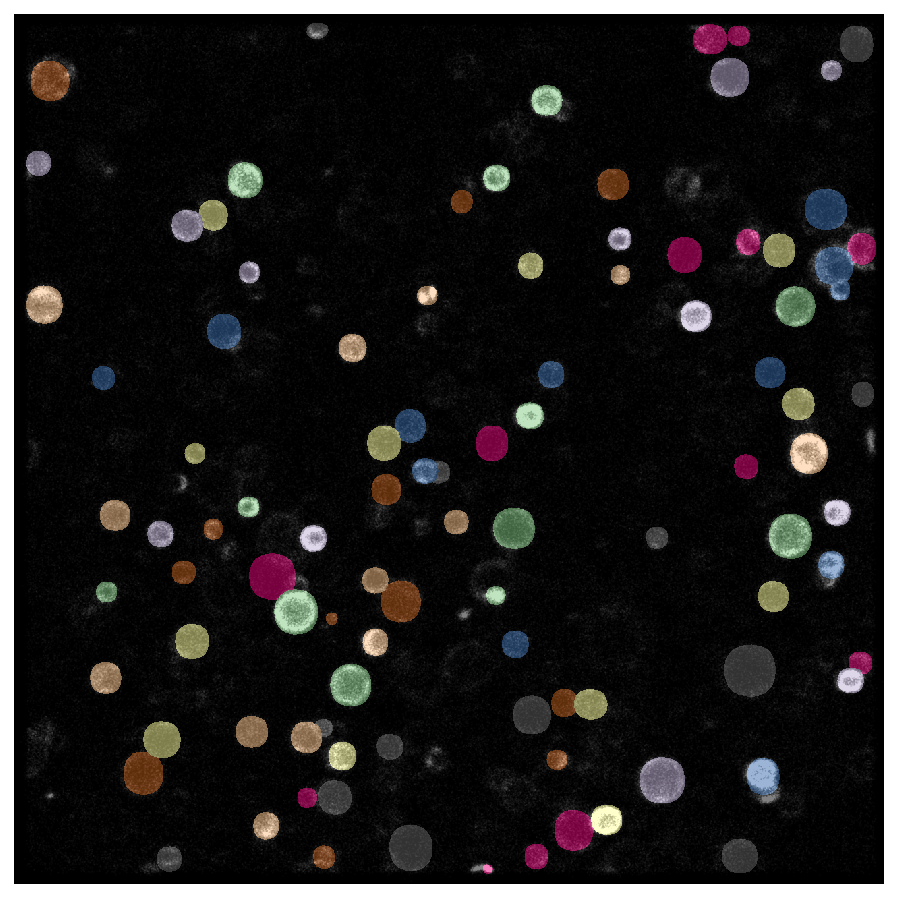

In [38]:
from matplotlib.colors import ListedColormap
pastel1_colors = ListedColormap(plt.cm.Accent(np.linspace(0, 1, 256)))
pastel1_cmap = pastel1_colors(np.arange(256))
pastel1_cmap[:, -1] = 1
pastel1_cmap[0] = [0, 0, 0, 1]
pastel1_cmap[1] = [1, 1, 1, 1]
pastel1_cmap = ListedColormap(pastel1_cmap)
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
#lbl_cmap
#pastel1_cmap
plt.imshow(labels, cmap=pastel1_cmap, alpha=0.5)
plt.axis('off');
plt.savefig(path + r"\20220427_mask.png",dpi=600)

In [39]:
print(np.max(labels))

99


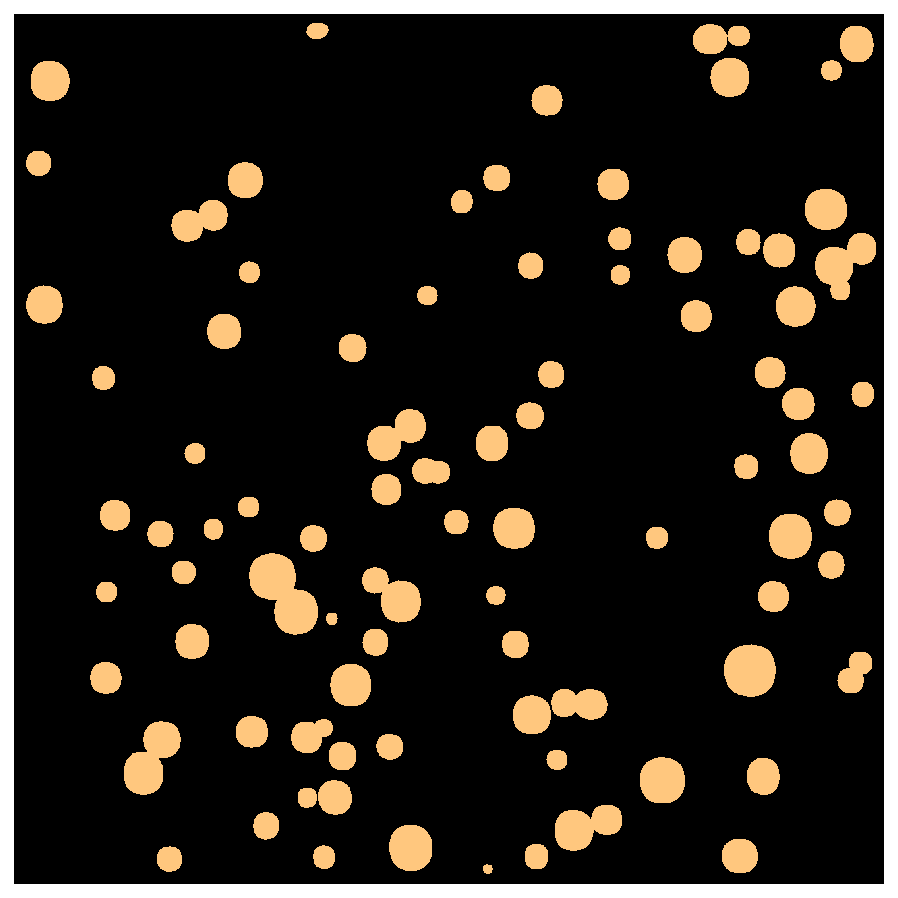

In [40]:
data = pd.DataFrame(labels)
data.to_csv( path + '\labelbodi.csv',  index=False)

labels2 = labels
labels3 = labels
plt.figure(figsize=(8,8))
#plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
labels2[labels2 != 0] = 100
labels3[labels2 != 0] = 20000
data = pd.DataFrame(labels3)
data.to_csv( path + '\Maskbodi.csv',  index=False)
plt.imshow(labels2,cmap='copper' )
plt.axis('off');
plt.box(False)
plt.savefig(path + '\Maskbodi.png',dpi=600)

In [49]:
directory = input("Enter the directory path where the CSV file is located: ")
filename = input("Enter the CSV file name: ")

# Combine the directory path and filename
file_path = directory + '/' + filename

# Read the CSV file using pandas
df = pd.read_csv(file_path)

# Convert the dataframe to a 2D array
csv_data = df.values

labels = csv_data
path = directory

Enter the directory path where the CSV file is located:  c
Enter the CSV file name:  m


FileNotFoundError: [Errno 2] No such file or directory: 'c/m'

In [42]:
s = np.shape(labels)
dr = np.zeros(s)
print(s)
x = (np.where(labels==5))[1]
y = (np.where(labels==5))[0]
col1 = "xmin"
col2 = "xmax"
col3 = "ymin"
col4 = "ymax"
data = pd.DataFrame(labels)
data.to_csv( path+'\label.csv',  index=False)

co = int(np.max(labels))
print(co)
xmin = np.array([None]*co)
xmax = np.array([None]*co)
ymin = np.array([None]*co)
ymax = np.array([None]*co)
R_fit = np.array([None]*co)
for i in range(co):
    x = (np.where(labels==i + 1))[1]
    y = (np.where(labels==i + 1))[0]
    xmin[i] = min(x) 
    xmax[i] = max(x) 
    ymin[i] = min(y) 
    ymax[i] = max(y) 
    R_fit[i] = (((xmax[i] - xmin[i])/2) + ((ymax[i] - ymin[i])/2))/2
    
data2 = pd.DataFrame({col1:xmin,col2:xmax,col3:ymin,col4:ymax});
data2.to_csv( path + '\Droplets_coardinateaant.csv',  index=False)
data3 = pd.DataFrame({col1:R_fit});
data3.to_csv( path + '\R_fitpix.csv',  index=False)

(2160, 2160)
99


In [125]:
#= (4/(0.045*0.045))*3.14*A2*A2/1000000

In [143]:
check = (np.where(labels==1))[1]
check2 = max(check)

## Save predictions

Uncomment the lines in the following cell if you want to save the example image and the predictions to disk.  
See [this notebook](../other2D/export_imagej_rois.ipynb) for more details on how to export ImageJ ROIs.

In [61]:
#save_tiff_imagej_compatible('example_image.tif', img, axes='YX')
#save_tiff_imagej_compatible('example_labels.tif', labels, axes='YX')
#export_imagej_rois('example_rois.zip', details['coord'])

# Example results

1/1 [==============================] - 1s 1s/step


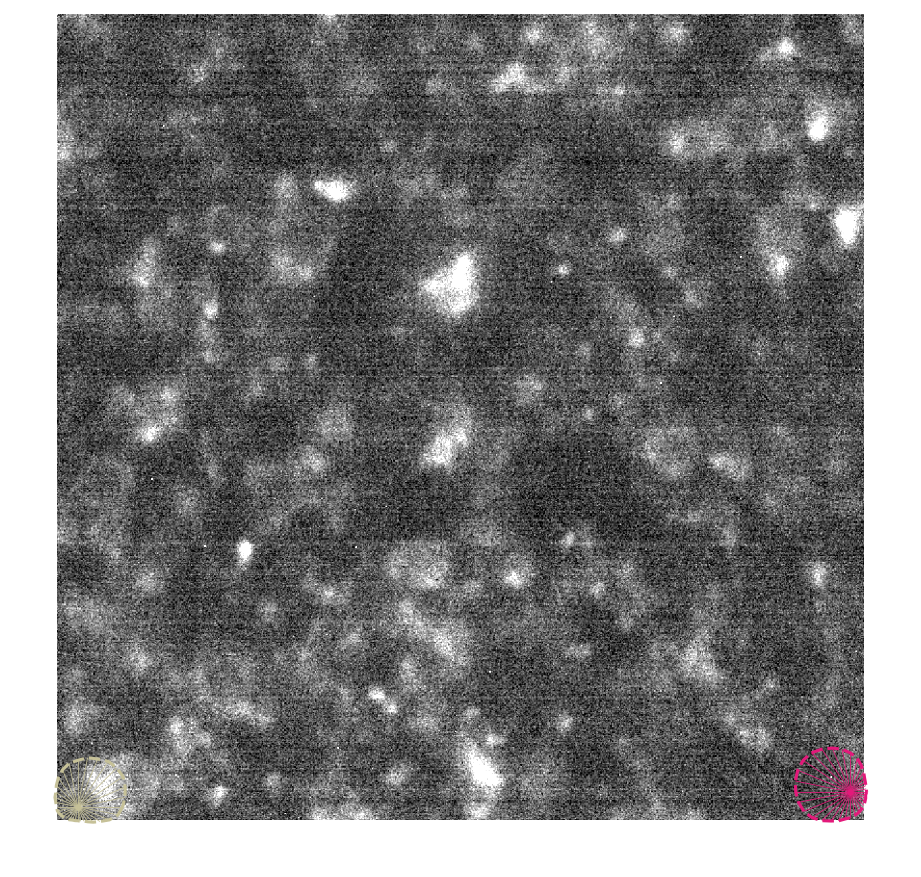

In [332]:

img = normalize(X[0], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)
plt.figure(figsize=(8,8))
coord, points, prob = details['coord'], details['points'], details['prob']
plt.imshow(img, cmap='gray'); plt.axis('off')
_draw_polygons(coord, points, prob, show_dist=True)
plt.savefig("20220427_style.png",dpi=600)

In [ ]:
example(model, 0)

# Model from paper

In [ ]:
model_paper = StarDist2D.from_pretrained('2D_paper_dsb2018')

In [ ]:
example(model_paper, 0)

# Versatile model

Try this model first if you have images that look similar to the training data in this example.

In [224]:
model_versatile = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [ ]:
example(model_versatile, 0, False)

Show all available pretrained models:

In [ ]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
